# Projeto Disciplina KDD & Desafio Axondata

## Foco: Covid-19

### Ideia 2
Realizar agrupamentos de séries temporais relativas ao COVID-19, pra verificar quais estados tem comportamentos similares em termos de casos óbitos.

Utiliza a base da Brasil.io no formato original, onde as linhas são as datas e as colunas representam casos, mortes e recuperados de COVID19, além de dados de doenças correlacionadas.

## Configuração Biblioteca e Spark

In [42]:
# importar bibliotecas necessárias
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window
from pyspark.sql.functions import col
import numpy as np
import pandas as pd
from fbprophet import Prophet

In [2]:
# criar contexto e configuração para o Spark
conf = SparkConf().setAppName("Covid-19 EDA")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

## Explorar Base de Dados - Brasil.io

In [99]:
# Schema para Ler os Dados dos Casos da Base Brasil.IO
schema_brasil_io = StructType([StructField('date', TimestampType(), True),
                        StructField('state', StringType(), True),
                        StructField('city', StringType(), True),
                        StructField('place_type', StringType(), True),
                        StructField('confirmed', IntegerType(), True),
                        StructField('deaths', IntegerType(), True),
                        StructField('num_days', IntegerType(), True),
                        StructField('is_last', BooleanType(), True),
                        StructField('estimated_population_2019', IntegerType(), True),
                        StructField('confirmed_by_100k_inhabitants', FloatType(), True),
                        StructField('death_rate', FloatType(), True)])

# ler arquivo de casos mundiais confirmados para dataframe Spark
brasil_io_cases = sqlContext.read.csv('../datasets/caso.csv', sep=',', header=True, schema=schema_brasil_io)

In [100]:
# Contagem de objetos do dataframe Brasil.io
print("Total de Objetos (base consolidada) : {}".format(brasil_io_cases.count()))

Total de Objetos (base consolidada) : 69395


In [101]:
# Estrutura Dataframe consolidado
brasil_io_cases.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- confirmed: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- num_days: integer (nullable = true)
 |-- is_last: boolean (nullable = true)
 |-- estimated_population_2019: integer (nullable = true)
 |-- confirmed_by_100k_inhabitants: float (nullable = true)
 |-- death_rate: float (nullable = true)



In [102]:
# listar 10 primeiras linhas do dataframe
brasil_io_cases.limit(10).toPandas()

,date,state,city,place_type,confirmed,deaths,num_days,is_last,estimated_population_2019,confirmed_by_100k_inhabitants,death_rate
0,2020-05-10,SE,None,state,1771,34,47,True,2298696,28.0,77.043678
1,2020-05-09,SE,None,state,1588,33,46,False,2298696,28.0,69.082649
2,2020-05-08,SE,None,state,1438,28,45,False,2298696,28.0,62.557209
3,2020-05-07,SE,None,state,1214,25,44,False,2298696,28.0,52.812550
4,2020-05-06,SE,None,state,998,23,43,False,2298696,28.0,43.415920
5,2020-05-05,SE,None,state,898,21,42,False,2298696,28.0,39.065632
6,2020-05-04,SE,None,state,772,17,41,False,2298696,28.0,33.584259
7,2020-05-03,SE,None,state,730,14,40,False,2298696,28.0,31.757139
8,2020-05-02,SE,None,state,601,14,39,False,2298696,28.0,26.145260
9,2020-05-01,SE,None,state,517,14,38,False,2298696,28.0,22.491011


In [104]:
# Ranking - Top 5 Cidades por Casos Confirmados
top_5_brasil_confirmed = brasil_io_cases.select('city','confirmed').filter("date == '2020-05-10' and place_type == 'city'").orderBy('confirmed', ascending=False).limit(5)
top_5_brasil_confirmed.show()

+--------------+---------+
|          city|confirmed|
+--------------+---------+
|     São Paulo|    27307|
|     Fortaleza|    11556|
|Rio de Janeiro|    10520|
|        Manaus|     7198|
|        Recife|     6984|
+--------------+---------+



In [105]:
# Ranking - Top 5 Cidades por Óbitos
top_5_brasil_deaths = brasil_io_cases.select('city','deaths').filter("date == '2020-05-10' and place_type == 'city'").orderBy('deaths', ascending=False).limit(5)
top_5_brasil_deaths.show()

+--------------+------+
|          city|deaths|
+--------------+------+
|     São Paulo|  2266|
|Rio de Janeiro|  1126|
|     Fortaleza|   840|
|        Manaus|   680|
|        Recife|   415|
+--------------+------+



In [106]:
# Cria filtro automatico de cidades para colocar no Gráfico

# filtro top 5 - casos confirmados
filter_confirmed_top5_cities = np.array(top_5_brasil_confirmed.select('city').collect(), dtype = 'object')
filter_confirmed_top5_cities = np.squeeze(filter_confirmed_top5_cities.reshape(filter_confirmed_top5_cities.shape[1], filter_confirmed_top5_cities.shape[0])).tolist()

# filtro top 5 - óbitos
filter_death_top5_cities = np.array(top_5_brasil_deaths.select('city').collect(), dtype = 'object')
filter_death_top5_cities = np.squeeze(filter_death_top5_cities.reshape(filter_death_top5_cities.shape[1], filter_death_top5_cities.shape[0])).tolist()

Text(0.5, 1.0, 'Curva de Óbitos - Top 5 Brasil')

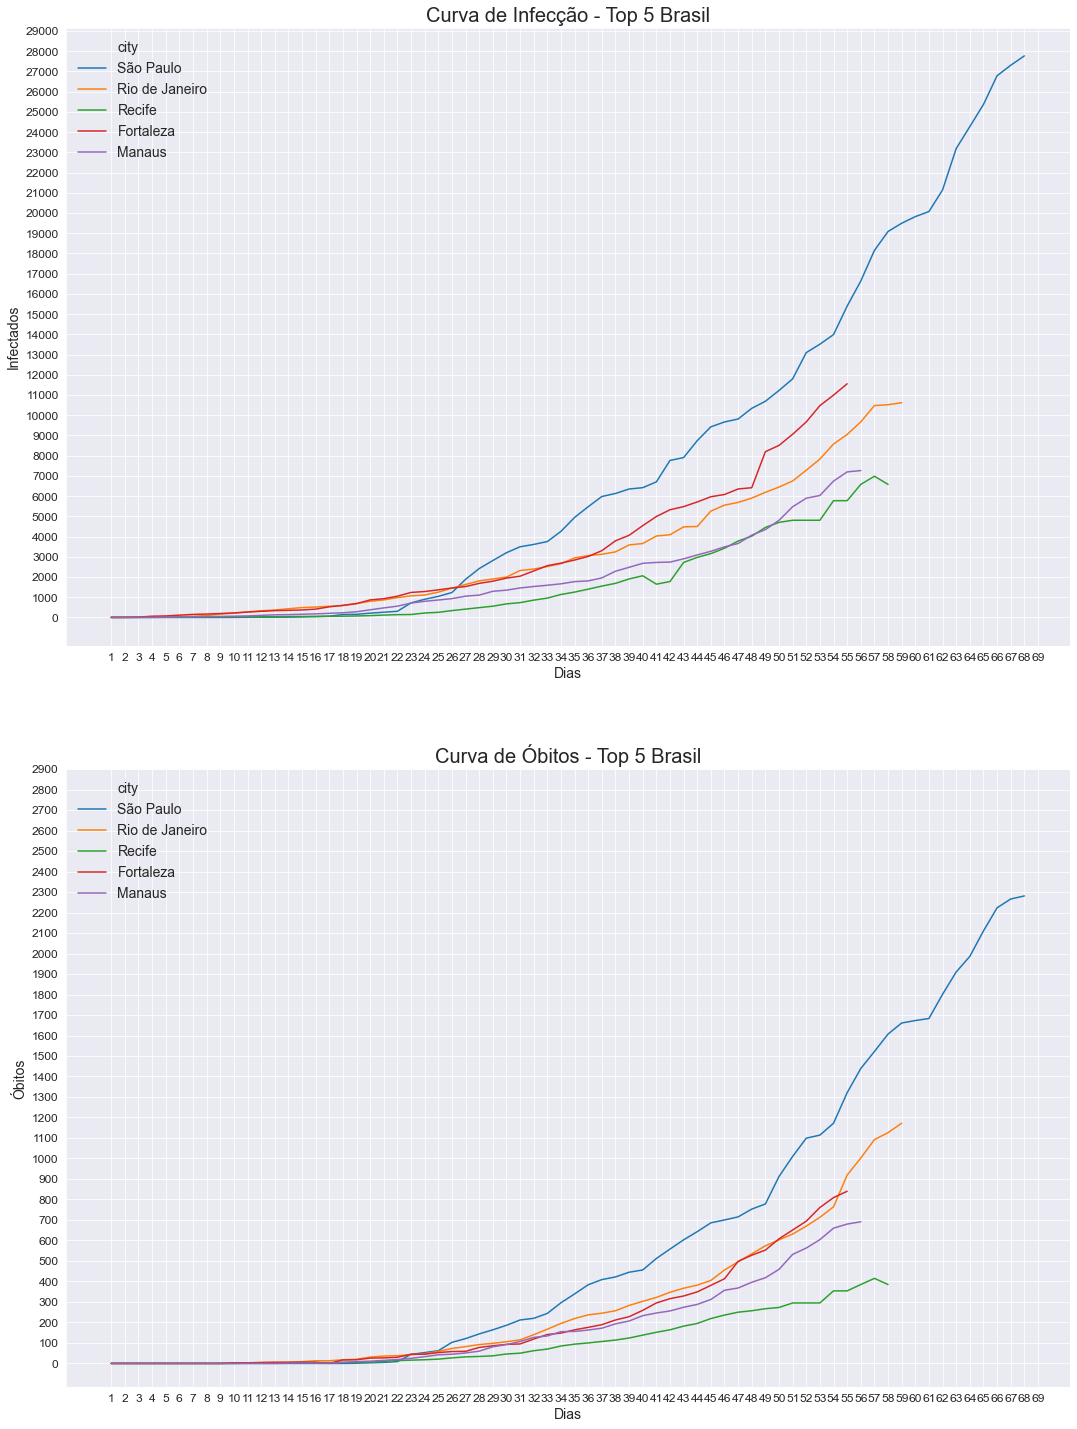

In [111]:
# Gerar gráficos comparando Top 5
fig_dims = (18, 25)
fig, ax = plt.subplots(figsize=fig_dims, nrows=2, ncols=1)
sns.set_style("darkgrid")

# Confirmados
sns.lineplot(x="num_days", y="confirmed", hue="city", ax=ax[0], data=brasil_io_cases.filter(brasil_io_cases.city.isin(filter_confirmed_top5_cities)).toPandas())
ax[0].set_xticks(np.arange(1, 70, 1.0))
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_yticks(np.arange(0, 30000, 1000.0))
ax[0].legend(fontsize=14, frameon=False)
ax[0].set_xlabel("Dias", fontsize=14)
ax[0].set_ylabel("Infectados", fontsize=14)
ax[0].set_title("Curva de Infecção - Top 5 Brasil", fontsize=20)

# Óbitos
sns.lineplot(x="num_days", y="deaths", hue="city", ax=ax[1], data=brasil_io_cases.filter(brasil_io_cases.city.isin(filter_death_top5_cities)).toPandas())
ax[1].set_xticks(np.arange(1, 70, 1.0))
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_yticks(np.arange(0, 3000, 100.0))
ax[1].legend(fontsize=14, frameon=False)
ax[1].set_xlabel("Dias", fontsize=14)
ax[1].set_ylabel("Óbitos", fontsize=14)
ax[1].set_title("Curva de Óbitos - Top 5 Brasil", fontsize=20)

In [ ]:
# Preparar dataframe para clustering

# remover colunas de province_state, lat, long, date
columns_to_drop = ['province_state', 'lat', 'long', 'date']
clustering_df = confirmed_world_cases.drop(*columns_to_drop)

In [ ]:
clustering_df.summary().show()

In [ ]:
# criar um dataframe, convertendo num_days em colunas (pivot)
clustering_pivot_df = clustering_df.groupby("country_region").pivot("num_days").sum("on_day")

In [ ]:
# criar numpy array, com values
clustering_array_np = np.array(clustering_pivot_df.select(clustering_pivot_df.columns[10:20]).limit(20).collect(), dtype=np.double)

In [ ]:
clustering_array_np.shape

In [ ]:
# imprimir array sem notação científica
np.set_printoptions(suppress=True)
clustering_array_np

In [ ]:
# Clustering
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
cluster_idx = model1.fit(clustering_array_np)
# Augment Hierarchical object to keep track of the full tree
model2 = clustering.HierarchicalTree(model1)
cluster_idx = model2.fit(clustering_array_np)

In [ ]:
# SciPy linkage clustering
model3 = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = model3.fit(clustering_array_np)

In [ ]:
cluster_idx

In [ ]:
model3.plot("plot.png")

## Datasets COVID19

- https://data.brasil.io/dataset/covid19/_meta/list.html
- https://github.com/CSSEGISandData/COVID-19
- https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
- https://github.com/beoutbreakprepared/nCoV2019?files=1
- https://www.kaggle.com/smid80/coronavirus-covid19-tweets
- https://www.kaggle.com/paultimothymooney/covid19-containment-and-mitigation-measures
- https://www.kaggle.com/unanimad/corona-virus-brazil
- https://docs.google.com/spreadsheets/d/1-kTZJZ1GAhJ2m4GAIhw1ZdlgO46JpvX0ZQa232VWRmw/edit#gid=2034285255
- https://github.com/github/covid-19-repo-data
- https://github.com/datasets/covid-19
- https://github.com/pomber/covid19
- https://github.com/joachim-gassen/tidy_covid19

## Dados Demográficos (Brasil e Mundo)

- https://data.worldbank.org/indicator/sp.pop.totl
- https://www.kaggle.com/crisparada/brazilian-cities
- https://www.kaggle.com/fernandol/countries-of-the-world

## Artigos, estudos e recursos - COVID-19
- https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8
- https://medium.com/data-for-science/epidemic-modeling-102-all-covid-19-models-are-wrong-but-some-are-useful-c81202cc6ee9
- https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html
- https://medium.com/@flohagenbuch/vemos-luz-no-fim-do-túnel-covid-19-96663d3cf1ed
- https://investnews.com.br/cafeina/novo-estudo-contesta-previsoes-sobre-mortes-pela-covid-19-no-brasil/
- https://science.sciencemag.org/content/early/2020/04/14/science.abb5793.full
- https://www.medrxiv.org/content/10.1101/2020.02.27.20028027v3
- https://towardsdatascience.com/5-datasets-about-covid-19-you-can-use-right-now-46307b1406a?gi=8f8a40a7b45b
- https://www.kaggle.com/brandao/covid19-reduzindo-falsos-negativos
- https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions
- https://towardsdatascience.com/top-5-r-resources-on-covid-19-coronavirus-1d4c8df6d85f

## Papers, Estudos, Artigos - Séries Temporais
- https://peerj.com/preprints/3190/